# DLCV Assignment 1

**Due Date: 22/02/2024 11:59PM IST**

**Name:**

**Sr. No.:**


In this assignment, we will cover the following topics:

1) Training a simple Linear Model

2) Implementing Modules with Backprop functionality

3) Implementing Convolution Module on Numpy


It is crucial to get down to the nitty gritty of the code to implement all of these. No external packages (like caffe,pytorch etc), which directly give functions for these steps, are to be used.

# Training a simple Linear Model

In this section, you will write the code to train a Linear Model. The goal is to classify an input $X_i$ of size $n$ into one of $m$ classes. For this, you need to consider the following:

1)  **Weight Matrix** $W_{n\times m}$: The Weights are multipled with the input $X_i$ (vector of size $n$), to find $m$ scores $S_m$ for the $m$ classes.

2)  **The Loss function**:   
  * The Cross Entropy Loss: By interpreting the scores as unnormalized log probabilities for each class, this loss tries to measure dissatisfaction with the scores in terms of the log probability of the right class:

$$
L_i = -\log\left(\frac{e^{f_{y_i}}}{ \sum_j e^{f_j} }\right) \hspace{0.5in} \text{or equivalently} \hspace{0.5in} L_i = -f_{y_i} + \log\sum_j e^{f_j}
$$

where $f_{ y_i }$ is the $y_i$-th element of the output of $W^T  X_i$

3) **A Regularization term**: In addition to the loss, you need a Regularization term to lead to a more distributed (in case of $L_2$) or sparse (in case of $L_1$) learning of the weights. For example, with $L_2$ regularization, the loss has the following additional term:

$$
R(W) = \sum_k\sum_l W_{k,l}^2  
$$

Thus the total loss has the form:
$$
L =  \underbrace{ \frac{1}{N} \sum_i L_i }_\text{data loss} + \underbrace{ \lambda R(W) }_\text{regularization loss} \\\\
$$

4) **An Optimization Procedure**: This refers to the process which tweaks the weight Matrix $W_{n\times m}$ to reduce the loss function $L$. In our case, this refers to Mini-batch Gradient Descent algorithm. We adjust the weights $W_{n\times m}$, based on the gradient of the loss $L$ w.r.t. $W_{n\times m}$. This leads to:
$$
W_{t+1} = W_{t} - \alpha \frac{\partial L}{\partial W},
$$
where $\alpha$ is the learning rate. Additionally, with "mini-batch" gradient descent, instead of finding loss over the whole dataset, we use a small sample $B$ of the training data to make each learning step. Hence,
$$
W_{t+1} = W_{t} - \alpha \frac{\partial \sum_{i \in B}{L_{x_i}}}{\partial W},
$$
where $|B|$ is the batch size.

# Question 1

Train a **Single-Layer Classifier** for the MNIST dataset.
* Use Softmax-Loss.
* Maintain a train-validation split of the original training set for finding the right value of $\lambda$ for the regularization, and to check for over-fitting.
* Finally, evaluate the classification performance on the test-set.


In [ ]:
import numpy as np # linear algebra
import struct
from array import array
from os.path  import join
import random
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img

        return np.array(images), np.array(labels)

    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)


In [ ]:
## Load The Mnist data:
# Download data from http://yann.lecun.com/exdb/mnist/
# load the data.
def loadData():
  input_path = '/content/drive/MyDrive/IISC/Second Semester/DLCV/archive'
  training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
  training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
  test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
  test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')
  mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
  (x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()
  x_train = x_train/255
  x_test = x_test/255
  y_train = createLabels(y_train)
  y_test = createLabels(y_test)
  return (x_train, y_train), (x_test, y_test)

def createLabels(labels):
  new_labels = np.zeros((labels.size, labels.max() + 1))
  new_labels[np.arange(labels.size), labels] = 1
  return new_labels

# maintain a train-val split
def splitDateTrainVal(x_data, y_data, train_split = 0.8):
  datalength = len(x_data)
  trainSplit = train_split
  valSplit = 1- train_split

  train_size = int(datalength * trainSplit)
  val_size = datalength - train_size

  x_train = x_data[:train_size].reshape(train_size, -1).T
  y_train = y_data[:train_size]
  x_val = x_data[train_size:].reshape(datalength - train_size, -1).T
  y_val = y_data[train_size:]

  return x_train, y_train, x_val, y_val

# Now, write a generator that yields (random) mini-batches of the input data
# Do not use same set of mini-batches for different epochs

def get_minibatch(training_x, training_y, batchSize = 32, index = 1):
    ## Read about Python generators if required.

    ## WRITE CODE HERE
    mini_x = []
    mini_y = []
    sequence = random.sample(range(training_x.shape[1]), training_x.shape[1])
    count = 1
    for i in range(training_x.shape[index]):
      mini_x.append(training_x[:, sequence[i]])
      mini_y.append(training_y[sequence[i]])
      if(len(mini_x) == batchSize):
        yield np.array(mini_x).T, np.array(mini_y)
        mini_x = []
        mini_y = []

    if mini_x:
      yield np.array(mini_x).T, np.array(mini_y)

In [ ]:

# Define the class for a Single Layer Classifier
class Single_layer_classifier():

    def __init__(self, input_size, output_size, mean = 0, variance = 1e-3):

        ## WRITE CODE HERE

        # Give the instance a weight matrix, initialized randomly
        # One possible strategy for a good initialization is Normal (0, σ) where σ = 1e-3.
        # Try experimenting with different values of σ.
        self.Weights = np.random.normal(mean, variance, (output_size, input_size))

    # Define the forward function
    def forward(self, input_x):

        # get the scores

        ## WRITE CODE HERE
        scores = self.Weights @ input_x

        return scores

    # Similarly a backward function
    # we define 2 backward functions (as Loss = L_data + L_reg, grad(Loss) = grad(L1) + grad(L2))

    def backward_Ldata(self, grad_from_loss, input_x):

        # this function returns a matrix of the same size as the weights,
        # where each element is the partial derivative of the loss w.r.t. the corresponding element of W

        ## WRITE CODE HERE
        grad_matrix = grad_from_loss @ input_x.T
        return grad_matrix

    def backward_Lreg(self):

        # this function returns a matrix of the same size as the weights,
        # where each element is the partial derivative of the regularization-term
        # w.r.t. the corresponding element of W

        ## WRITE CODE HERE
        grad_matrix = 2 * self.Weights

        return grad_matrix

In [ ]:
# Implement the Softmax loss function
def loss_function(input_y,scores):
    ## WRITE CODE HERE
    max_scores = np.max(scores, axis=0, keepdims=True)  # Prevent overflow
    logsumexp = np.log(np.sum(np.exp(scores - max_scores), axis=0)) + max_scores
    loss = (-np.trace(input_y @ scores) + np.sum(logsumexp)) / len(input_y)
    return loss

# Backward pass for the negative log loss
def loss_backward(scores, input_y):
    # This part deals with the gradient of the loss w.r.t the output of network
    # for example, in case of softmax loss(-log(q_c)), this part gives grad(loss) w.r.t. q_c
    # pass this to backward_ldata

    ## WRITE CODE HERE
    grad_from_loss = np.zeros((len(scores)))
    for i in range(len(input_y)):
      max_score = np.max(scores[:, i])
      exp_scores = np.exp(scores[:, i] - max_score)
      softmax = exp_scores / np.sum(exp_scores)
      data = data = -(input_y.T[:, i] - softmax)
      grad_from_loss = np.vstack((grad_from_loss, data))
    grad_from_loss = grad_from_loss[1:].T / len(input_y)
    return grad_from_loss


### Create utility functions for calculating training and validation accuracy

In [ ]:
# WRITE CODE HERE
(x_train, y_train), (x_test, y_test) = loadData()
x_test = x_test.reshape(len(x_test), -1).T
x_train, y_train, x_val, y_val = splitDateTrainVal(x_train, y_train)

In [ ]:
# Finally the trainer:
# Make an instance of Single_layer_classifier
# Train for t epochs:
###  Train on the train-set obtained from train-validation split
###  Use the mini-batch generator to get each mini-batch

print("Start of Model Train")
def train_model(x_train, y_train, number_of_epochs=100, learning_rate = 1e-4, batch_size = 128):
  slcObj = Single_layer_classifier(784, 10)
  lossList = []
  accuracyList = []
  for i in range(number_of_epochs):
    minibatch = get_minibatch(x_train, y_train, batch_size)
    for iter_num,(mini_input_x , mini_input_y) in enumerate(minibatch):
        ## Write code here for each iteration of training

        # Forward pass
        scores = slcObj.forward(mini_input_x)
        loss = loss_function(mini_input_y, scores)
        lossList.append(loss)

        predicted_classes = np.argmax(scores, axis=0)
        true_classes = np.argmax(mini_input_y, axis=1)
        accuracy = np.mean(predicted_classes == true_classes) * 100
        accuracyList.append(accuracy)
        # Backward pass
        gradFromLoss = loss_backward(scores, mini_input_y)
        lossGradient = slcObj.backward_Ldata(gradFromLoss, mini_input_x)
        regLossGradient = slcObj.backward_Lreg()
        grad = lossGradient + 1e-4 * regLossGradient

        # Update weights
        slcObj.Weights -= learning_rate * grad

        # Log the training loss value and training accuracy
  # print(f"Iteration Number: {i} & loss: {loss} ")
  return slcObj, lossList, accuracyList

Start of Model Train


In [ ]:
slcObj, lossList, accuracyList = train_model(x_train, y_train, 40, 5e-3)

In [ ]:
def find_accuracy(slcObj, x, y):
  predictions = slcObj.forward(x)
  predicted_classes = np.argmax(predictions, axis=0)
  true_classes = np.argmax(y, axis=1)
  accuracy = np.mean(predicted_classes == true_classes) * 100
  return accuracy

In [ ]:
find_accuracy(slcObj, x_train, y_train)

89.83958333333332

### Plot the training loss and training accuracy plot

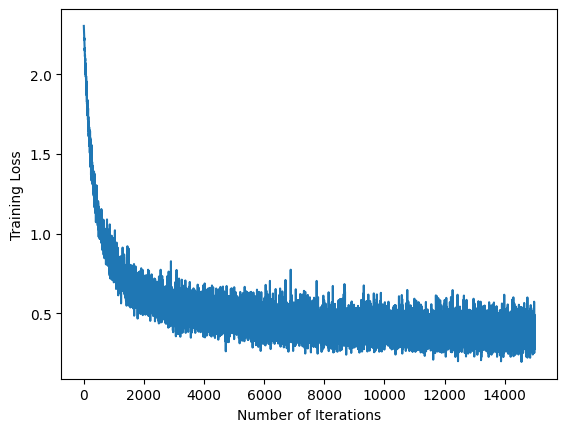

In [ ]:
# WRITE CODE HERE
#Plot the training Loss
plt.plot(lossList)
plt.xlabel("Number of Iterations")
plt.ylabel("Training Loss")
plt.show()

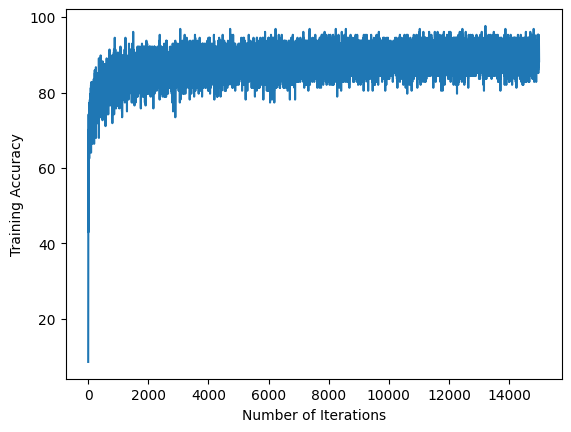

In [ ]:
#Plot the training accuracies
plt.plot(accuracyList)
plt.xlabel("Number of Iterations")
plt.ylabel("Training Accuracy")
plt.show()

In [ ]:
### Find the accuracy on the validation set

In [ ]:
# WRITE CODE HERE
#Calculating the accuracy on the validation set.
accuracy_val = find_accuracy(slcObj, x_val, y_val)
print(f"Accuracy of the model on the validation dataset is : {accuracy_val}")

Accuracy of the model on the validation dataset is : 90.60000000000001


In [ ]:
# The next step is to find the optimal value for lambda, number of epochs, learning rate and batch size.
# CHOSE ANY TWO from the above mentioned to tune.
# Create plot and table to show the effect of the hparams.
number_of_epochs = [10, 20]
learning_rates = [1e-3, 3e-3, 7e-3, 9e-3]
best_accuracy = 0
best_number_of_epochs = None
best_learning_rate = None
for j in range (len(number_of_epochs)):
  for k in range (len(learning_rates)):
      slcObj, lossList, accuracyList = train_model(x_train, y_train, number_of_epochs[j], learning_rates[k])
      accuracy = find_accuracy(slcObj, x_val, y_val)
      if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_number_of_epochs = number_of_epochs[j]
        best_learning_rate = learning_rates[k]
        print(f"Updated Parameters: Number of Epochs: {number_of_epochs[j]}, Learning Rate: {learning_rates[k]}, Accuracy: {accuracy}")

Updated Parameters: Number of Epochs: 10, Learning Rate: 0.001, Accuracy: 84.29166666666667
Updated Parameters: Number of Epochs: 10, Learning Rate: 0.003, Accuracy: 87.31666666666666
Updated Parameters: Number of Epochs: 10, Learning Rate: 0.007, Accuracy: 89.06666666666668
Updated Parameters: Number of Epochs: 10, Learning Rate: 0.009, Accuracy: 89.46666666666667
Updated Parameters: Number of Epochs: 20, Learning Rate: 0.007, Accuracy: 90.17500000000001
Updated Parameters: Number of Epochs: 20, Learning Rate: 0.009, Accuracy: 90.44166666666666


In [ ]:
best_accuracy, best_number_of_epochs, best_learning_rate

(90.44166666666666, 20, 0.009)

In [ ]:
### Report final performance on MNIST test set

In [ ]:
# WRITE CODE HERE
#Calculating the accuracy on test Set
accuracy_test = find_accuracy(slcObj, x_test, y_test)

In [ ]:
print(f"Accuracy of the model on the test dataset is : {accuracy_test}")

Accuracy of the model on the test dataset is : 90.42999999999999


### Find the best performing class and the worst performing class

In [ ]:
# WRITE CODE HERE
#Find the best performing class and the worst performing class in terms of accuracy
def find_best_worst_class(slcObj, x_test, y_test, class_names = None):
    # Convert One-Hot Encoding to Class Indices
    predictions = slcObj.forward(x_test)
    predicted_labels = np.argmax(predictions, axis=0)
    num_classes = np.max(predicted_labels) + 1  # Get number of unique classes
    pred_labels = np.eye(num_classes)[predicted_labels]
    true_labels = y_test
    # Find unique classes
    unique_classes = np.unique(y_test)
    class_accuracies = {}

    for c in unique_classes:
        total = np.sum(true_labels == c)  # Total occurrences of class c
        correct = np.sum((true_labels == c) & (pred_labels == c))  # Correct predictions
        accuracy = correct / total if total > 0 else 0
        class_name = class_names[c] if class_names else f"Class {c}"
        class_accuracies[class_name] = accuracy

    # Find best and worst performing classes
    best_class = max(class_accuracies, key=class_accuracies.get)
    worst_class = min(class_accuracies, key=class_accuracies.get)

    return best_class, worst_class


best_class, worst_class = find_best_worst_class(slcObj, x_test, y_test)

print(f"Best Performing Class: {best_class}")
print(f"Worst Performing Class: {worst_class}")

Best Performing Class: Class 0.0
Worst Performing Class: Class 1.0


# Training a Linear Classifier on MNIST from scikit-learn

In this section you have to train a linear classifier from the scikit-learn library and compare its results against your implementation.
(https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

In [ ]:
# WRITE CODE HERE
#Train a linear classifier from the scikit-learn library
import sklearn as sk
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logisticRegression = LogisticRegression(max_iter = 1000)
y_train_1d = np.argmax(y_train, axis=1)
logisticRegression.fit(x_train.T, y_train_1d)

LogisticRegression(max_iter=1000)

### Compare the training and test accuracies for the your implementation and linear classifier from scikit-learn

In [ ]:
# WRITE CODE HERE
predictions = logisticRegression.predict(x_test.T)
y_test_1d = np.argmax(y_test, axis=1)
accuracy = accuracy_score(y_test_1d, predictions)
print(f"Accuracy of the model on the validation dataset is : {accuracy*100}")

Accuracy of the model on the validation dataset is : 92.49000000000001


### Any additional observations / comments?

We can see that the accuracy of the model is better than our implementation(40 epochs and 5e-3 learning rate as hyperparameters)

## BONUS Question
### Observe the effect on test set accuracy by changing the number of training samples.
### Train on 10%, 20% and 50% training data and plot the percentage of training data v.s. the test accuracy.  

In [ ]:
# WRITE CODE HERE
train_pecentages = [0.1, 0.2, 0.5]
accuracy_trainList = []
accuracy_testList = []
(x_train, y_train), (x_test, y_test) = loadData()
x_test = x_test.reshape(len(x_test), -1).T
for train_percentage in train_pecentages:
  x_train_split, y_train_split, x_val_split, y_val_split  = splitDateTrainVal(x_train, y_train, train_percentage)

  slcObj, lossList, accuracyLis = train_model(x_train_split, y_train_split)
  accuracy_train = find_accuracy(slcObj, x_train_split, y_train_split)
  accuracy_trainList.append(accuracy_train)

  accuracy_test = find_accuracy(slcObj, x_test, y_test)
  accuracy_testList.append(accuracy_test)
  print(f"Accuracy of the model on the {train_percentage * 100} % train Data is {accuracy_train} and on the test dataset is : {accuracy_test}")

Accuracy of the model on the 10.0 % train Data is 75.6 and on the test dataset is : 74.65
Accuracy of the model on the 20.0 % train Data is 77.66666666666666 and on the test dataset is : 77.01
Accuracy of the model on the 50.0 % train Data is 81.49333333333333 and on the test dataset is : 82.54


# Implementing Backpropagation

Now that you have had some experience with single layer networks, we can proceed to more complex architectures. But first we need to completely understand and implement backpropagation.

## Backpropagation:

Simply put, a way of computing gradients of expressions through repeated application of chain rule. If
$$
L = f (g (h (\textbf{x})))
$$
then, by the chain rule we have:
$$
\frac{\partial L}{\partial \textbf{x}} = \frac{\partial f}{\partial g} \cdot \frac{\partial g}{\partial h} \cdot \frac{\partial h}{\partial \textbf{x}}
$$

** Look into the class Lecture for more detail **



# Question 2 : Scalar Backpropagation

Evaluate the gradient of the following function w.r.t. the input:

$$ f(x,y,z) =  log(\sigma(\frac{cos(\pi \times x)+sin(\pi \times y/2)}{tanh(z^2)}))$$
where $\sigma$ is the sigmoid function. Find gradient for the following inputs:
  * $(x,y,z)$ =  (2,4,1)
  * $(x,y,z)$ =  (9,14,3)
  * $(x,y,z)$ =  (128,42,666)
  * $(x,y,z)$ =  (52,14,28)

      

In [ ]:
class Cos():
    def forward(self, x):
        self.x = x
        return np.cos(x)

    def backward(self, grad_out):
        return -grad_out * np.sin(self.x)

class Sin():
    def forward(self, x):
        self.x = x
        return np.sin(x)

    def backward(self, grad_out):
        return grad_out * np.cos(self.x)

class Tanh():
    def forward(self, x):
        self.x = x
        self.tanh_x = np.tanh(x)
        return self.tanh_x

    def backward(self, grad_out):
        return grad_out * (1 - self.tanh_x ** 2)

class Square():
    def forward(self, x):
        self.x = x
        return x ** 2

    def backward(self, grad_out):
        return grad_out * 2 * self.x

class Addition():
    def forward(self, a, b):
        self.a, self.b = a, b
        return a + b

    def backward(self, grad_out):
        return grad_out, grad_out  # Derivative of addition is 1 w.r.t. both inputs

class Division():
    def forward(self, a, b):
        self.a, self.b = a, b
        return a / b

    def backward(self, grad_out):
        return grad_out / self.b, -grad_out * self.a / (self.b ** 2)

class Log():
    def forward(self, x):
        self.x = x
        return np.log(x)

    def backward(self, grad_out):
        return grad_out / self.x



In [ ]:
# To solve this problem, construct the computational graph
# Write a class with forward and backward functions, for each node if you like
# For eg:

class Sigmoid():
    def forward(self, x):
        self.x = x
        self.sigmoid_x = 1 / (1 + np.exp(-x))
        return self.sigmoid_x

    # save values useful for backpropagation
    def backward(self, grad_out):
        return grad_out * self.sigmoid_x * (1 - self.sigmoid_x)


# CAUTION: Carefully treat the input and output dimension variation. At worst, handle them with if statements.

In [ ]:
# Now write the class func
# which constructs the graph (all operators), forward and backward functions.

class Func():
    def __init__(self):
      # construct the graph here
      # assign the instances of function modules to self.var
      self.cos = Cos()
      self.sin = Sin()
      self.square = Square()
      self.tanh = Tanh()
      self.add = Addition()
      self.div = Division()
      self.sigmoid = Sigmoid()
      self.log = Log()

    def forward(self,x,y,z):
      # Using the graph element's forward functions, get the output.
      self.x_pi = np.pi * x
      self.y_pi_half = np.pi * y / 2
      self.cos_x = self.cos.forward(self.x_pi)
      self.sin_y = self.sin.forward(self.y_pi_half)
      self.sum_xy = self.add.forward(self.cos_x, self.sin_y)

      self.z_sq = self.square.forward(z)
      self.tanh_z_sq = self.tanh.forward(self.z_sq)
      self.div_xy_tanh = self.div.forward(self.sum_xy, self.tanh_z_sq)

      self.sigmoid_out = self.sigmoid.forward(self.div_xy_tanh)
      self.output = self.log.forward(self.sigmoid_out)

      return self.output

    def backward(self, output):
      # Use the saved outputs of each module, and backward() function calls
      grad_log = self.log.backward(1)  # df/dlog_output
      grad_sigmoid = self.sigmoid.backward(grad_log)  # df/dsigmoid_output
      grad_div_xy_tanh, grad_tanh_z_sq = self.div.backward(grad_sigmoid)

      grad_sum_xy, grad_tanh = self.add.backward(grad_div_xy_tanh)

      grad_cos_x = self.cos.backward(grad_sum_xy)
      grad_sin_y = self.sin.backward(grad_sum_xy)

      grad_x = grad_cos_x * np.pi
      grad_y = grad_sin_y * (np.pi / 2)

      grad_z_sq = self.tanh.backward(grad_tanh)
      grad_z = self.square.backward(grad_z_sq)

      return [grad_x, grad_y, grad_z]


In [ ]:
funcObj = Func()
values = [(2,4,1), (9,14,3), (128,42,666), (52,14,28)]


In [ ]:
output_list = []
grad_list = []
for i in values:
  output = funcObj.forward(i[0], i[1], i[2])
  output_list.append(output)
  print(f"For the value {i}, the value of the function is {output}")
  grad = funcObj.backward(output)
  grad_list.append(grad)
  print(f"For the value {i}, the gradiuent of the function is {grad}")
  print("")

For the value (2, 4, 1), the value of the function is -0.23823101469115085
For the value (2, 4, 1), the gradiuent of the function is [2.1417102890343507e-16, 0.43720979194276516, 0.23378829118225147]

For the value (9, 14, 3), the value of the function is -1.3132617097862374
For the value (9, 14, 3), the gradiuent of the function is [-2.5313688314302287e-15, -1.148344174369598, 2.6721617938240487e-07]

For the value (128, 42, 666), the value of the function is -0.31326168751822314
For the value (128, 42, 666), the gradiuent of the function is [1.3244281103803985e-14, -0.42245219681098717, 0.0]

For the value (52, 14, 28), the value of the function is -0.31326168751822253
For the value (52, 14, 28), the gradiuent of the function is [-6.626324387577344e-15, -0.42245219681098645, 0.0]



## Question 3 : Modular Vector Backpropagation

* Construct a Linear Layer module, implementing the forward and backward functions for arbitrary sizes.
* Construct a ReLU module, implementing the forward and backward functions for arbitrary sizes.
* Create a 2 layer MLP using the constructed modules.

* Modifying the functions built in Question 1 , train this two layer MLP for the same data set, MNIST, with the same train-val split.

In [ ]:
# Class for Linear Layer using modular approach(If you're stuck, you can refer to code of PyTorch/Tensorflow packages)
class Linear():
  def __init__(self, input_size, output_size):
    sigma = np.sqrt(2/(input_size + output_size))
    self.weights = np.random.normal(0, sigma, size=(output_size, input_size))

  def forward(self, input_x):
    self.input_x = input_x
    self.output = np.dot(self.weights, input_x)
    return self.output

  def backward(self, grad_from_loss):
    self.grad_weights = np.dot(grad_from_loss, self.input_x.T)
    self.grad_input = np.dot(self.weights.T, grad_from_loss)
    return self.grad_weights, self.grad_input

In [ ]:
# Class for ReLU
class Relu():
    def forward(self, input_x):
        self.input_x = input_x
        self.output = np.maximum(0, input_x)
        return self.output

    def backward(self, grad_from_loss):
      self.grad_input = np.where(self.input_x > 0, grad_from_loss, 0)
      return self.grad_input

In [ ]:
# Your 2 layer MLP
class MLP():
    def __init__(self, input_size, hidden_size, output_size):
        self.linear1 = Linear(input_size, hidden_size)
        self.relu = Relu()
        self.linear2 = Linear(hidden_size, output_size)

    def forward(self, input_x):
        self.linear1_output = self.linear1.forward(input_x)
        self.relu_output = self.relu.forward(self.linear1_output)
        self.linear2_output = self.linear2.forward(self.relu_output)
        return self.linear2_output

    def backward(self, grad_from_loss):
        self.linear2_grad_weights, self.linear2_grad_input = self.linear2.backward(grad_from_loss)
        self.relu_grad_input = self.relu.backward(self.linear2_grad_input)
        self.linear1_grad_weights, self.linear1_grad_input = self.linear1.backward(self.relu_grad_input)
        return self.linear2_grad_weights, self.linear1_grad_weights

In [ ]:
# WRITE CODE HERE
(x_train, y_train), (x_test, y_test) = loadData()
x_test = x_test.reshape(len(x_test), -1).T
x_train, y_train, x_val, y_val = splitDateTrainVal(x_train, y_train)
x_train.shape, y_train.shape

((784, 48000), (48000, 10))

In [ ]:
# Train the MLP
print("Start of Model Train")
def train_model_MLP(x_train, y_train, number_of_epochs=100, learning_rate = 1e-4):
  mlpObj = MLP(len(x_train), 300,len(y_train[0]))
  lossList = []
  accuracyList = []
  for i in range(number_of_epochs):
    minibatch = get_minibatch(x_train, y_train)
    for iter_num,(mini_input_x , mini_input_y)in enumerate(minibatch):
        ## Write code here for each iteration of training

        # Forward pass
        scores = mlpObj.forward(mini_input_x)
        loss = loss_function(mini_input_y, scores)
        lossList.append(loss)
        accuracy = find_accuracy(mlpObj, mini_input_x, mini_input_y)
        accuracyList.append(accuracy)

        # Backward pass
        gradFromLoss = loss_backward(scores, mini_input_y)
        linear2_grad_weights, linear1_grad_weights = mlpObj.backward(gradFromLoss)

        # Update weights
        mlpObj.linear1.weights -= learning_rate * linear1_grad_weights
        mlpObj.linear2.weights -= learning_rate * linear2_grad_weights

        # Log the training loss value and training accuracy
  print(f"Iteration Number: {i} & loss: {loss} ")
  return mlpObj, lossList, accuracyList

Start of Model Train


In [ ]:
mlpObj, lossList, accuracyList = train_model_MLP(x_train, y_train, 30, 5e-3)

Iteration Number: 29 & loss: 0.16263477031592188 


### Plot the training loss and training accuracy plot

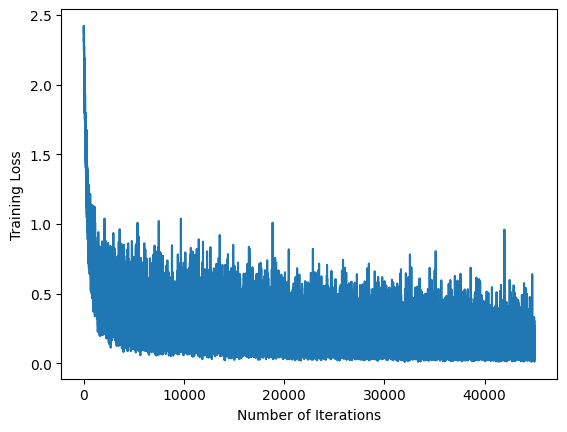

In [ ]:
# Use the same utility functions defined in the previous question
# WRITE CODE HERE
#Plot the training Loss
plt.plot(lossList)
plt.xlabel("Number of Iterations")
plt.ylabel("Training Loss")
plt.show()

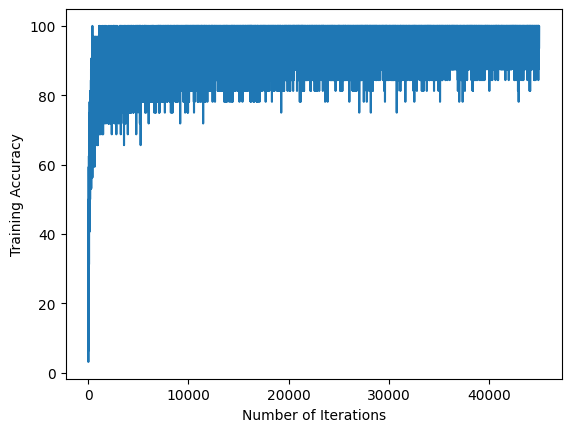

In [ ]:
#Plot the accuracy
plt.plot(accuracyList)
plt.xlabel("Number of Iterations")
plt.ylabel("Training Accuracy")
plt.show()

In [ ]:
### Find the accuracy on the validation set
accuracy = find_accuracy(mlpObj, x_val, y_val)
print(f"Accuracy of the model on the validation dataset is : {accuracy}")

Accuracy of the model on the validation dataset is : 96.00833333333333


In [ ]:
# WRITE CODE HERE

In [ ]:
# Find the optimal value of learning rate and batch size.
# Use the same tuning strategy as the previous question
# Create plot and table to show the effect of the hparams.
# The next step is to find the optimal value for lambda, number of epochs, learning rate and batch size.
# CHOSE ANY TWO from the above mentioned to tune.
# Create plot and table to show the effect of the hparams.
number_of_epochs = [10,20]
learning_rates = [1e-3, 3e-3]
best_accuracy = 0
best_number_of_epochs = None
best_learning_rate = None
for j in range (len(number_of_epochs)):
  for k in range (len(learning_rates)):
      slcObj, lossList, accuracyList = train_model_MLP(x_train, y_train, number_of_epochs[j], learning_rates[k])
      accuracy = find_accuracy(slcObj, x_val, y_val)
      if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_number_of_epochs = number_of_epochs[j]
        best_learning_rate = learning_rates[k]
        print(f"Updated Parameters: Number of Epochs: {number_of_epochs[j]}, Learning Rate: {learning_rates[k]}, Accuracy: {accuracy}")

Iteration Number: 9 & loss: 5.958259016671093 
Updated Parameters: Number of Epochs: 10, Learning Rate: 0.001, Accuracy: 86.8
Iteration Number: 9 & loss: 9.277698772362328 
Updated Parameters: Number of Epochs: 10, Learning Rate: 0.003, Accuracy: 88.61666666666666
Iteration Number: 19 & loss: 1.5774382034373957 
Updated Parameters: Number of Epochs: 20, Learning Rate: 0.001, Accuracy: 88.64166666666667
Iteration Number: 19 & loss: 0.937695544411639 
Updated Parameters: Number of Epochs: 20, Learning Rate: 0.003, Accuracy: 90.88333333333334


In [ ]:
best_accuracy, best_number_of_epochs, best_learning_rate

(90.88333333333334, 20, 0.003)

In [ ]:
### Report final performance on MNIST test set
accuracy = find_accuracy(mlpObj, x_test, y_test)
print(f"Accuracy of the model on the test dataset is : {accuracy}")

Accuracy of the model on the test dataset is : 96.04


In [ ]:
# WRITE CODE HERE


### Find the best performing class and the worst performing class

In [ ]:
# WRITE CODE HERE
best, worst = find_best_worst_class(mlpObj, x_test, y_test)
print(f"Best Performing Class: {best}")
print(f"Worst Performing Class: {worst}")

Best Performing Class: 1.0
Worst Performing Class: 0.0


### Any additional observations / comments?

We can see that the 2 layer MLP performs better than the single layer MLP and  scikit learn in test accuracy.

## BONUS Question
### Observe the effect on test set accuracy by changing the number of training samples.
### Train on 10%, 20% and 50% training data and plot the percentage of training data v.s. the test accuracy.  

In [ ]:
# WRITE CODE HERE
train_pecentages = [0.1, 0.2, 0.5]
accuracy_percentagetrainList = []
accuracy_percentagetestList = []
(x_train, y_train), (x_test, y_test) = loadData()
x_test = x_test.reshape(len(x_test), -1).T
for train_percentage in train_pecentages:
  accuracy_trainList = []
  accuracy_testList = []
  x_train_split, y_train_split, x_val_split, y_val_split  = splitDateTrainVal(x_train, y_train, train_percentage)

  mlpObj, lossList, accuracyList = train_model_MLP(x_train_split, y_train_split, 10, 5e-3)
  accuracy_train = find_accuracy(mlpObj, x_train_split, y_train_split)
  accuracy_trainList.append(accuracy_train)

  accuracy_test = find_accuracy(mlpObj, x_test, y_test)
  accuracy_testList.append(accuracy_test)
  accuracy_percentagetrainList.append(accuracy_trainList)
  accuracy_percentagetestList.append(accuracy_testList)
  print(f"Accuracy of the model on the {train_percentage * 100} % train Data is {accuracy_train} and on the test dataset is : {accuracy_test}")

Iteration Number: 9 & loss: 0.3333015507084589 
Accuracy of the model on the 10.0 % train Data is 89.71666666666667 and on the test dataset is : 88.61
Iteration Number: 9 & loss: 0.45045050535825126 
Accuracy of the model on the 20.0 % train Data is 91.19166666666668 and on the test dataset is : 90.05
Iteration Number: 9 & loss: 0.5861344862338838 
Accuracy of the model on the 50.0 % train Data is 92.67333333333333 and on the test dataset is : 92.78999999999999



# Implementing a Convolution Module with Numpy

* This topic will require you to implement the Convolution operation using Numpy.
* We will use the Module for tasks like Blurring.
* Finally, we implement Backpropagation for the convolution module.


## Question 4

* Implement a naive Convolution module, with basic functionalities: kernel_size, padding, stride and dilation
  
* Test out the convolution layer by using it to do gaussian blurring on 10 random images of CIFAR-10 dataset


In [ ]:
## Define a class Convolution Layer, which is initialized with the various required params:
class Convolution_Layer():

  def __init__(self, in_channel, filter_size, out_channel,stride=1, padding=0, bias=True, dilation=1):
      # For an untrained layer, set random initial filter weights
      self.filter_size = filter_size
      self.out_channel = out_channel
      self.bias = bias
      self.stride = stride
      self.padding = padding
      self.dilation = dilation
      self.filter_weight = np.ones((out_channel, in_channel, filter_size, filter_size))
      if(self.dilation > 1):
        new_dilaiton_size = self.dilation * (self.filter_size -1) + 1
        newWeight = np.zeros((out_channel, in_channel, new_dilaiton_size, new_dilaiton_size))
        for i in range(self.filter_size):
          for j in range(self.filter_size):
            newWeight[:, :, i*self.dilation, j*self.dilation] = self.filter_weight[:, :, i, j]
        self.filter_weight = newWeight
        self.filter_size = new_dilaiton_size



  def forward(self,input, perChannel = False):
      # Input Proprocess(According to pad etc.) Input will be of size (Batch_size, in_channels, inp_height, inp_width)

      # Reminder: Save Input for backward-prop
      # Simple Conv operation:
      # Loop over every location in inp_height * inp_width for the whole batch
      batch_size, in_channels, inp_height, inp_width = input.shape
      out_height = (inp_height + 2 * self.padding - self.filter_size) // self.stride + 1
      out_width = (inp_width + 2 * self.padding - self.filter_size) // self.stride + 1

      if(out_height< 0 or out_width < 0):
          print(out_width)
          raise Exception("Invalid Operation")

      out_channels = self.out_channel
      out_height = int(out_height)
      out_width = int(out_width)
      output = np.zeros((batch_size, out_channels, out_height, out_width))
      self.input = np.pad(input, ((0, 0), (0, 0), (self.padding, self.padding), (self.padding, self.padding)), 'constant')

      for batch in range(batch_size):
          for channel in range(out_channels):
              for i in range(out_height):
                  for j in range(out_width):
                    if(perChannel):

                      output[batch, channel, i, j] =  np.sum(self.input[batch,
                                                                  channel,
                                                                  i*self.stride:i*self.stride + self.filter_size,
                                                                  j*self.stride:j*self.stride + self.filter_size]
                                                            * self.filter_weight[channel])
                    else:
                      output[batch, channel, i, j] =  np.sum(self.input[batch,
                                                                  :,
                                                                  i*self.stride:i*self.stride + self.filter_size,
                                                                  j*self.stride:j*self.stride + self.filter_size]
                                                            * self.filter_weight[channel])

      # Output will be of the size (Batch_size, out_channels, out_height, out_width)
      return output

  def backward(self, grad_of_output_size):

      # Naive Implementation
      # Speed is not a concern
      # Hint: gradients from each independant operation can be summed

      #  return gradient of the size of the weight kernel
      batch_size, in_channels, inp_height, inp_width = self.input.shape
      filter_size = int((self.filter_size - 1)/ self.dilation + 1)
      grad_of_weights = np.zeros((self.out_channel, in_channels, filter_size, filter_size))

      if(self.stride > 1):
        new_filter_size = grad_of_output_size.shape[2]
        new_dilaiton_size = self.stride * (new_filter_size -1) + 1
        dilatedGradOutput = np.zeros((grad_of_output_size.shape[0], grad_of_output_size.shape[1], new_dilaiton_size, new_dilaiton_size))

        for i in range(new_filter_size):
          for j in range(new_filter_size):
            dilatedGradOutput[:, :, i*self.stride, j*self.stride] = grad_of_output_size[:, :, i, j]

        grad_of_output_size = dilatedGradOutput
      grad_of_output_size = np.transpose(grad_of_output_size, (1,0,2,3))
      input = np.transpose(self.input, (1,0,2,3))

      # calculating the grad of weights
      for batch in range(batch_size):
        for channel in range(in_channels):
          for out_channel in range(self.out_channel):
            for i in range(filter_size):
              for j in range(filter_size):
                grad_of_weights[out_channel, channel, i, j] = np.sum(input[channel,
                                                              batch,
                                                              i*self.dilation:i*self.dilation + grad_of_output_size.shape[2],
                                                              j*self.dilation:j*self.dilation + grad_of_output_size.shape[3]]
                                                        * grad_of_output_size[out_channel, batch, :, :])
      grad_of_output_size = np.transpose(grad_of_output_size, (1,0,2,3))
      return grad_of_weights

  def set_weights(self, new_weights):
      ## Replace the set of weights with the given 'new_weights'
      ## use this for setting weights for blurring, bilateral filtering etc.
      ## new_weights is of size (in_channel, filter_size, filter_size)
      if(self.dilation > 1):
        new_filter_size = new_weights.shape[2]
        new_dilaiton_size = self.dilation * (new_filter_size -1) + 1
        newWeightFilter = np.zeros((new_weights.shape[0], new_weights.shape[1], new_dilaiton_size, new_dilaiton_size))

        for i in range(new_filter_size):
          for j in range(new_filter_size):
            newWeightFilter[:, :, i*self.dilation, j*self.dilation] = new_weights[:, :, i, j]
        self.filter_weight = newWeightFilter
        self.filter_size = new_dilaiton_size
        self.out_channel = new_weights.shape[0]
      else:
        self.filter_size = new_weights.shape[2]
        self.filter_weight = new_weights
        self.out_channel = new_weights.shape[0]

In [ ]:
### Download CIFAR-10 images and load it in a numpy array (https://www.cs.toronto.edu/~kriz/cifar.html)
import pickle
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
path = '/content/drive/MyDrive/IISC/Second Semester/DLCV/cifar-10-batches-py/'
x_train=unpickle(path + 'data_batch_1')
x_train=x_train[b'data']
for i in ['2','3','4','5']:
    data1=unpickle(path + 'data_batch_'+i)
    data1=data1[b'data']
    x_train=np.concatenate([x_train,data1],axis=0)
x_test=unpickle(path + 'test_batch')
x_test=x_test[b'data']


In [ ]:
# WRITE CODE HERE
x_train = x_train.reshape(50000, 3, 32, 32)
x_test = x_test.reshape(10000, 3, 32, 32)
x_train.shape, x_test.shape

((50000, 3, 32, 32), (10000, 3, 32, 32))

### Initialize a conv layer. Set weights for gaussian blurring (do not train the filter for this part). Visualise the filters using matplotlib


In [ ]:
def gaussian_kernel(size, sigma=1):
    """Generates a 2D Gaussian kernel."""
    ax = np.linspace(-(size // 2), size // 2, size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    return kernel / np.sum(kernel)


In [ ]:
# WRITE CODE HERE
# use the gaussian blurring filter in the Conv Layer weights
conv = Convolution_Layer(1, 5, 1, stride=1, padding=2, bias=False, dilation=1)
new_weights= gaussian_kernel(5).reshape(1, 1, 5, 5)
new_weights_out_channeled = np.zeros((3, 1, 5, 5))
for i in range(3):
  new_weights_out_channeled[i] = new_weights
new_weights = new_weights_out_channeled

In [ ]:
conv.set_weights(new_weights)
output_iamge = conv.forward(x_train[0].reshape(1, 3,32,32), perChannel = True).astype(np.uint8)

In [ ]:
output_iamge.shape

(1, 3, 32, 32)

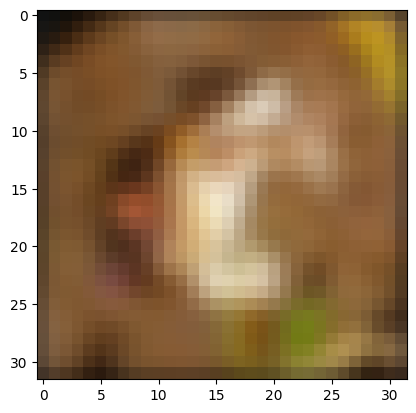

In [ ]:
plt.imshow(output_iamge.reshape(3, 32, 32).T)
plt.show()

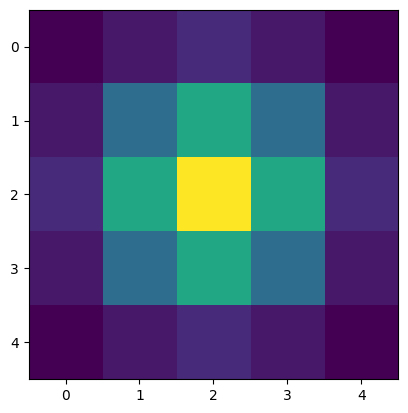

In [ ]:
#Visualizing the Gaussian Blurring filter
plt.imshow(new_weights[0].reshape( 1,5,5).T)
plt.show()

### Generate output for the first 5 images of the training set

In [ ]:
new_weights= gaussian_kernel(5).reshape(1, 1, 5, 5)
new_weights_out_channeled = np.zeros((3, 1, 5, 5))
for i in range(3):
  new_weights_out_channeled[i] = new_weights
new_weights = new_weights_out_channeled

In [ ]:
# WRITE CODE HERE
image_list = []
conv = Convolution_Layer(3, 5, 3, stride=1, padding=2, bias=False, dilation=1)
conv.set_weights(new_weights)
for i in range(5):
  output_img = conv.forward(x_train[i].reshape(1, 3,32,32), perChannel = True).astype(np.uint8)
  image_list.append(output_img)

### Use matplotlib to show the input and corresponding blurred output

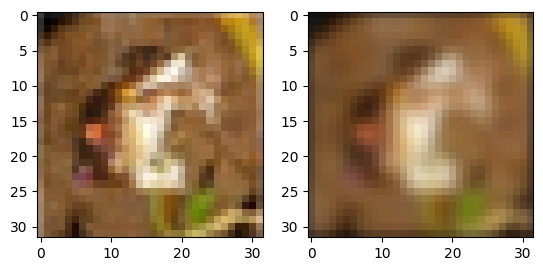

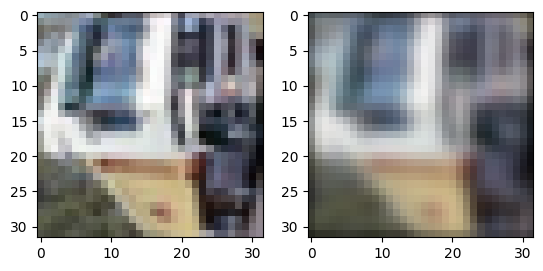

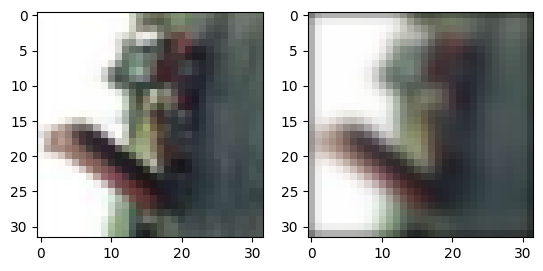

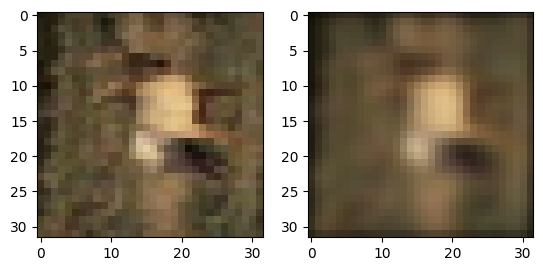

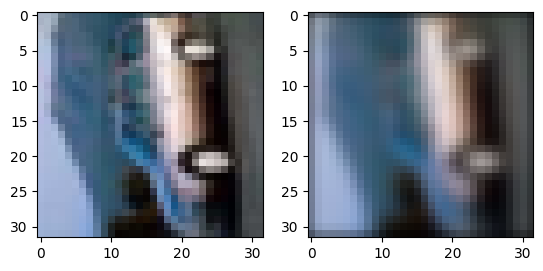

In [ ]:
# WRITE CODE HERE
for i in range(5):
  plt.subplot(1, 2, 1)
  plt.imshow(x_train[i].reshape(3,32,32).T)
  plt.subplot(1, 2, 2)
  plt.imshow(image_list[i].reshape(3,32,32).T)
  plt.show()

## Question 5
<br>
Now we will use this module for training a simple Convolution Layer using CIFAR-10 images.

* The goal is to learn a set of weights, by using the backpropagation function created. To test the backpropagation, instead of training a whole network, we will train only a single layer.
  * Instantiate a Convolution  layer $C_0$ with 20 filters, each with size 5$\times$5 (RGB image, so 3 input channels). Load the given numpy array of size (20,3,5,5), which represents the weights of a convolution layer. Set the given values as the filter weights for $C_0$. Take 100 CIFAR-10 images. Save the output of these 100 images generated from this Convolution layer $C_0$.
  
  * Now, initialize a new convolution layer $C$ with weight values sampled from uniform distribution [-1,1]. Use the $L_2$ loss between the output of this layer $C$ and the output generated in the previous step to learn the filter weights of $C_0$.


In [ ]:
## Load filter weights from given numpy array "C0_weights.npy".
filter_weight = np.load("/content/drive/MyDrive/IISC/Second Semester/DLCV/C0_weights.npy")
filter_weight.shape
## Init a conv layer C_0 with these given weights
conv_0 = Convolution_Layer(3, 5, 20, stride=1, padding=2, bias=False, dilation=1)
conv_0.set_weights(filter_weight)
## For all images get output. Store in numpy array.
output_list = []
for i in range(10):
  output_img = conv_0.forward(x_train[i].reshape(1, 3,32,32)).astype(np.uint8)
  output_list.append(output_img)


In [ ]:
output_list = np.array(output_list).reshape(10, 20, 32, 32)
output_list.shape

(10, 20, 32, 32)

In [ ]:
def get_minibatch_images(training_x, batchSize = 32, index = 0):
    ## Read about Python generators if required.

    ## WRITE CODE HERE
    mini_x = []
    sequence = random.sample(range(training_x.shape[index]), training_x.shape[index])
    count = 1
    for i in range(training_x.shape[index]):
      mini_x.append(training_x[sequence[i], :, :, :])
      if(len(mini_x) == batchSize):
        yield np.array(mini_x)
        mini_x = []

    if mini_x:
      yield np.array(mini_x).T

In [ ]:
# for part 2 we need to write a class for the  L2 loss
class L2_loss():
    def ___init__(self):
      self.loss = 0


    def forward(self, C0_output,C_output):
        # Conv. output is of dimension (batchsize,channels,height,width)
        # calculate the L2 norm of (C0_output - C_output)
        # differnce = C0_output - C_output
        differnce = C_output - C0_output
        loss = np.sum(differnce**2)
        self.differnce = differnce
        self.loss = loss
        return loss

    def backward(self):
        # from the loss, and the conv. output, get the grad at each location
        # The grad is of the shape (batchsize,channels,height,width)
        grad = 2 * self.differnce
        return grad

# Now Init a new conv layer C and a L2 loss layer


# Train the new conv-layer C using the L2 loss to learn C_0, i.e., the set of given weights.
# Use mini-batches if required
def train_model_CNN(conv, conv0, l2_loss, learning_rate = 1e-3, max_iteration = 100, batch_size = 128):
  loss_list = []
  for i in range(max_iteration):
    minibatch = get_minibatch_images(x_train[:100], batch_size, index = 0)
    avg_loss = 0
    for iter_num,(mini_input_x)in enumerate(minibatch):
      # print(iter_num)
      c_output_list = []
      c0_output_list = []
      mini_input_x = mini_input_x.reshape(len(mini_input_x), 3,32,32)
      c_output = conv.forward(mini_input_x/255)
      c0_output = conv_0.forward(mini_input_x/255)

      loss = l2_loss.forward(c0_output, c_output)
      # print(loss)

      loss_list.append(loss)
      grad = l2_loss.backward()
      grad_weights = conv.backward(grad)
      conv.filter_weight -= learning_rate * grad_weights
      avg_loss += loss

    avg_loss = avg_loss / (iter_num + 1)
    print(avg_loss)


# Print L2 dist between output from the new trained convolution layer C and the outputs generated from C_0.


In [ ]:
conv = Convolution_Layer(3, 5, 20, stride=1, padding=2, bias=False, dilation=1)
conv_0 = Convolution_Layer(3, 5, 20, stride=1, padding=2, bias=False, dilation=1)
conv_0.set_weights(filter_weight)
conv.set_weights(np.random.uniform(-1, 1, (20, 3, 5, 5)))
l2_loss = L2_loss()
train_model_CNN(conv,conv_0, l2_loss, 5e-5, 100, 1)

27255.096890568984
3053.7709426142596
3587.0572264383522
1351.0094621725768
1139.0648031863043
938.5047322121976
813.9673173012994
726.6367729194067
655.3531222265045
599.3580251145098
553.3477621952101
513.7903284275486
485.4037070647492
444.3017561703028
418.7864516663019
390.9270971299928
371.7683086777974
350.917644748183
335.650818493533
314.31461381686904
299.49376324900527
286.63412875745956
273.4411168306351
262.09159538474216
253.08409860239928
245.90386778834875
230.98980418808958
225.2012494959051
214.4748579015721
207.99362287098992
211.33026319054142
193.69589868308026
187.9062925246803
183.5712094044433
177.4960410992415
171.40816097726648
168.34923342186244
163.4177490293075
159.0592369407276
155.52242762715036
152.0938542938651
146.204946778652
144.66559771333118
139.6032002297958
136.457636913552
134.70823271552482
130.54154889259672
127.38779684805006
125.5098778106077
135.41677129425872
119.64855347188445
117.27841429477311
114.88540257128587
112.58883857198529
110.8

In [ ]:
training_data = x_train[:100]
training_data = training_data.reshape(100, 3, 32, 32)
c_output = conv.forward(training_data/255)
c0_output = conv_0.forward(training_data/255)

In [ ]:
l2_norm = np.linalg.norm(c0_output - c_output)
print(f"L2 norm between the two outputs is {l2_norm}")

L2 norm between the two outputs is 75.29393946336664
